## Good resource for multi-class classification in sklearn:
https://towardsdatascience.com/comprehensive-guide-to-multiclass-classification-with-sklearn-127cc500f362

In [149]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dateutil

from sklearn.datasets import make_regression, make_classification
from sklearn.model_selection import (
    cross_val_score, cross_val_predict,
    RepeatedKFold, RepeatedStratifiedKFold,
    train_test_split, 
)
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn.metrics import (
    roc_auc_score,
    roc_curve, RocCurveDisplay, auc,
    confusion_matrix,
    multilabel_confusion_matrix,
    plot_roc_curve,
    plot_precision_recall_curve,
    ConfusionMatrixDisplay,
)

import sklearn
print(sklearn.__version__)

1.0.2


In [2]:
# animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
# diabetic = [1076, 1082, 1101]
# impaired = [1060, 1062, 1074, 1092, 1102]
# normal = [1091, 1093]

# obs = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='cleaned')
# obs['animal'] = obs['animal'].str.strip('TM').astype('int')
# obs['datetime'] = obs['when'].apply(dateutil.parser.parse)
# animal_phenotypes = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='animal phenotypes')
# animal_phenotypes['animal'] = animal_phenotypes['animal'].str.strip('TM').astype('int')

# fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)
# df = pd.read_csv(r'..\data\processed\combined_metab_lipid_table.csv', index_col=0)
# data_cols = df.filter(regex='FBG|RBG').columns
# pval_cols = df.filter(regex='pval').columns

In [3]:
animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic = [1076, 1082, 1101]
impaired = [1060, 1062, 1074, 1092, 1102]
normal = [1091, 1093]

obs = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='cleaned')
obs['animal'] = obs['animal'].str.strip('TM').astype('int')
obs['datetime'] = obs['when'].apply(dateutil.parser.parse)
animal_phenotypes = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='animal phenotypes')
animal_phenotypes['animal'] = animal_phenotypes['animal'].str.strip('TM').astype('int')

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Use data that was sent to collaborators 
data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data_cols = data.filter(regex='FBG|RBG').columns
fbg_cols = data.filter(regex='FBG').columns
rbg_cols = data.filter(regex='RBG').columns
pval_cols = data.filter(regex='pval').columns

n = data.filter(regex='1091|1093')                 # normal
i = data.filter(regex='1060|1062|1074|1092|1102')  # impaired
d = data.filter(regex='1076|1082|1101')            # diabetic

f = data[fbg_cols]  # fasted
r = data[rbg_cols]  # random-fed

fn = n.filter(fbg_cols)  # fasted normal 
fi = i.filter(fbg_cols)  # fasted impaired
fd = d.filter(fbg_cols)  # fasted diabetic

rn = n.filter(rbg_cols)  # random normal
ri = i.filter(rbg_cols)  # random impaired
rd = d.filter(rbg_cols)  # random diabetic

# rename columns to remove '_RBG', '_FBG' for element-wise subtraction
rn.columns = rn.columns.str[:-4]
fn.columns = fn.columns.str[:-4]
ri.columns = ri.columns.str[:-4]
fi.columns = fi.columns.str[:-4]
rd.columns = rd.columns.str[:-4]
fd.columns = fd.columns.str[:-4]

qval_sampling = data['fdr corrected pval effect of sampling']
# qval_sampling.replace(np.nan, 1, inplace=True)  # For replacing blanks (model failed to converge) with 1
qval_gtol = data['fdr corrected pval effect of glucose tolerance']
qval_cross = data['fdr corrected pval effect of interaction sampling and glucose tolerance']

## Perform 3 experiments
1. RF classification (N/I/D) with all features
1. RF classification (N/I/D) with only features that converged under full model
2. RF classification (N/I/D) with only features significant under glucose tolerance and glucose tolerance x sampling

## Hypothesis: RF is robust to non-informative features, so leave-one-out CV will show all 3 models perform approximately the same



In [64]:
# Generate data labels (y) for RF Classifier 

y_3class = fg.set_index('combined_col_name')['glucose_tolerance']
y_3class_num = y_3class.map({'normal': 0, 'impaired': 1, 'diabetic': 2})
print(y_3class)
y_continuous = fg.set_index('combined_col_name')['bg']
y_continuous

combined_col_name
1076_10_FBG    diabetic
1062_8_FBG     impaired
1093_9_FBG       normal
1060_8_RBG     impaired
1091_10_FBG      normal
1092_9_RBG     impaired
1093_10_RBG      normal
1082_10_FBG    diabetic
1060_9_RBG     impaired
1101_9_FBG     diabetic
1062_10_RBG    impaired
1091_8_RBG       normal
1074_10_FBG    impaired
1101_10_RBG    diabetic
1076_9_FBG     diabetic
1092_9_FBG     impaired
1074_8_FBG     impaired
1091_10_RBG      normal
1082_9_FBG     diabetic
1076_8_RBG     diabetic
1060_8_FBG     impaired
1093_9_RBG       normal
1060_10_FBG    impaired
1082_10_RBG    diabetic
1074_9_RBG     impaired
1091_9_RBG       normal
1101_10_FBG    diabetic
1093_8_FBG       normal
1074_8_RBG     impaired
1102_10_RBG    impaired
1062_9_FBG     impaired
1076_9_RBG     diabetic
1092_8_FBG     impaired
1062_10_FBG    impaired
1102_8_RBG     impaired
1074_10_RBG    impaired
1060_9_FBG     impaired
1082_9_RBG     diabetic
1076_10_RBG    diabetic
1091_9_FBG       normal
1102_9_FBG     impaire

combined_col_name
1076_10_FBG     71.000000
1062_8_FBG      52.333333
1093_9_FBG      64.000000
1060_8_RBG     225.000000
1091_10_FBG     48.500000
1092_9_RBG      70.500000
1093_10_RBG     69.500000
1082_10_FBG     50.000000
1060_9_RBG      83.000000
1101_9_FBG      43.000000
1062_10_RBG    139.500000
1091_8_RBG     108.500000
1074_10_FBG     55.000000
1101_10_RBG    352.000000
1076_9_FBG      78.500000
1092_9_FBG      63.500000
1074_8_FBG     171.333333
1091_10_RBG     71.500000
1082_9_FBG      53.333333
1076_8_RBG     387.666667
1060_8_FBG      41.000000
1093_9_RBG      83.000000
1060_10_FBG     52.500000
1082_10_RBG    330.500000
1074_9_RBG     203.500000
1091_9_RBG      86.000000
1101_10_FBG     44.500000
1093_8_FBG      47.000000
1074_8_RBG     232.500000
1102_10_RBG    308.000000
1062_9_FBG      48.000000
1076_9_RBG     281.000000
1092_8_FBG      46.000000
1062_10_FBG     40.000000
1102_8_RBG     299.500000
1074_10_RBG    205.500000
1060_9_FBG      48.000000
1082_9_RBG     339.5

## 3 training data sets:
### 1) RF classifier with all features
### 2) RF classifier with only features that converged under full model
### 3) RF classification (N/I/D) with only features significant under glucose tolerance and glucose tolerance interaction with sampling (gluc_tol x feeding)

In [6]:
X_all = data[data_cols].T
X_only_conv = data.loc[~data[pval_cols].isna().all(axis=1), data_cols].T
gluc_tol_cols = ['fdr corrected pval effect of glucose tolerance', 
                 'fdr corrected pval effect of interaction sampling and glucose tolerance']
X_only_signf = data.loc[(data[gluc_tol_cols] < 0.05).any(axis=1), data_cols].T

In [14]:
rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=100)
cv = RepeatedStratifiedKFold(n_splits=12, n_repeats=1, random_state=100)
n_scores = cross_val_score(estimator=rfc,
                           X=X_all,
                           y=y,
                           cv=cv,
                           scoring='accuracy', 
                           n_jobs=-1,
                           error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

NameError: name 'df' is not defined

In [8]:
rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=100)
cv = RepeatedStratifiedKFold(n_splits=12, n_repeats=1, random_state=100)
n_scores = cross_val_score(estimator=rfc,
                           X=X_only_conv,
                           y=y,
                           cv=cv,
                           scoring='accuracy', 
                           n_jobs=-1,
                           error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.750 (0.144)


In [10]:
rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=100)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=100)
n_scores = cross_val_score(estimator=rfc,
                           X=X_only_signf,
                           y=y,
                           cv=cv,
                           scoring='accuracy', 
                           n_jobs=-1,
                           error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.700 (0.135)


## Another experiment:
2. RF with indicator variable {0, 1} for FBG/RBG in training data 

## Hypothesis: mild increase in accuracy. 

In [12]:
sampling_indicator_var = fg.set_index('combined_col_name')['bg_type'].map({'FBG': 0, 'RBG': 1})

In [13]:
rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=100)
cv = RepeatedStratifiedKFold(n_splits=12, n_repeats=5, random_state=100)
n_scores = cross_val_score(estimator=rfc, X=X_all.join(sampling_indicator_var), y=y, cv=cv,
                           scoring='accuracy', n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.687 (0.177)


In [40]:
rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=100)
cv = RepeatedStratifiedKFold(n_splits=12, n_repeats=5, random_state=100)
n_scores = cross_val_score(estimator=rfc, X=X_only_conv.join(sampling_indicator_var), y=y, cv=cv,
                           scoring='accuracy', n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.710 (0.165)


([<matplotlib.axis.XTick at 0x234ff095a88>,
 [Text(0.1, 0, '20'),
  Text(1.1, 0, '40'),
  Text(2.1, 0, '60'),
  Text(3.1, 0, '80'),
  Text(4.1, 0, '100')])

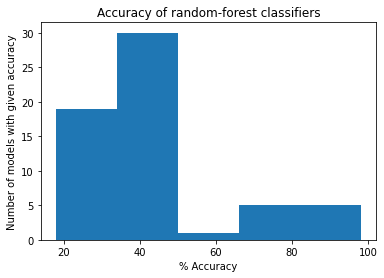

In [67]:
plt.hist([str(x) for x in n_scores*100], bins=5)
plt.title('Accuracy of random-forest classifiers')
plt.xlabel('% Accuracy')
plt.ylabel('Number of models with given accuracy')
plt.xticks(ticks=[0.1 + x for x in[0, 1, 2, 3, 4]], labels=[20, 40, 60, 80, 100])

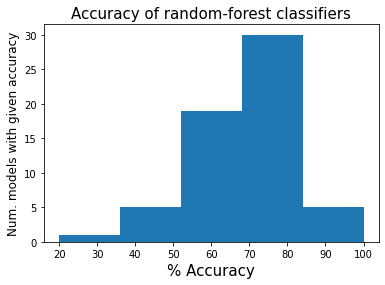

In [75]:
plt.hist(n_scores*100, bins=5)
plt.title('Accuracy of random-forest classifiers', fontsize=15)
plt.xlabel('% Accuracy', fontsize=15)
plt.ylabel('Num. models with given accuracy', fontsize=12)
# plt.xticks(ticks=[0.1 + x for x in[0, 1, 2, 3, 4]], labels=[20, 40, 60, 80, 100])
plt.savefig(r'..\reports\figures\3-5-2\RF_classifier_accuracy.png')

In [74]:
np.mean(n_scores)

0.7099999999999999

In [15]:
rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=100)
cv = RepeatedStratifiedKFold(n_splits=12, n_repeats=3, random_state=100)
n_scores = cross_val_score(estimator=rfc, X=X_only_signf.join(sampling_indicator_var), y=y, cv=cv,
                           scoring='accuracy', n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.703 (0.173)


(array([ 9.,  0.,  0., 17.,  0.,  0., 28.,  0.,  0.,  6.]),
 array([0.4 , 0.46, 0.52, 0.58, 0.64, 0.7 , 0.76, 0.82, 0.88, 0.94, 1.  ]),
 <BarContainer object of 10 artists>)

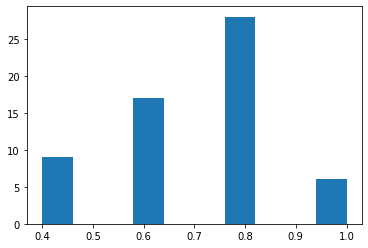

In [16]:
plt.hist(n_scores)

## RF Regressor

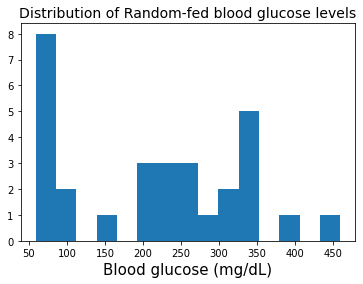

In [83]:
plt.hist(y_continuous[y_continuous.index.str.contains('RBG')], bins=15)
plt.title('Distribution of Random-fed blood glucose levels', fontsize=14)
plt.xlabel('Blood glucose (mg/dL)', fontsize=15)
plt.savefig(r'..\reports\figures\3-5-2\random_fed_blood_gluc_distribution.png')

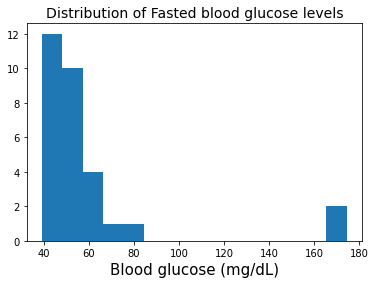

In [84]:
plt.hist(y_continuous[y_continuous.index.str.contains('FBG')], bins=15)
plt.title('Distribution of Fasted blood glucose levels', fontsize=14)
plt.xlabel('Blood glucose (mg/dL)', fontsize=15)
plt.savefig(r'..\reports\figures\3-5-2\fasted_blood_gluc_distribution.png')

In [34]:
rfr = RandomForestRegressor()  

# evaluate the model
## To do leave-one-out, set n_splits = n_observations in your training data 
cv = RepeatedKFold(n_splits=60, n_repeats=3, random_state=1)
n_scores = cross_val_score(estimator=rfr, 
#                            X=X_only_signf.join(sampling_indicator_var), 
                           X=X_only_signf,
                           y=y_continuous, 
                           scoring='neg_mean_absolute_error', 
                           cv=cv, 
                           n_jobs=-1, 
                           error_score='raise')
# report performance
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

MAE: -25.302 (38.365)


In [85]:
rfr = RandomForestRegressor()  

# evaluate the model
## To do leave-one-out, set n_splits = n_observations in your training data 
cv = RepeatedKFold(n_splits=60, n_repeats=3, random_state=1)
rfr_scores = cross_val_score(estimator=rfr, 
                           X=X_only_signf.join(sampling_indicator_var), 
#                            X=X_only_signf,
                           y=y_continuous, 
                           scoring='neg_mean_absolute_error', 
                           cv=cv, 
                           n_jobs=-1, 
                           error_score='raise')
# report performance
print('MAE: %.3f (%.3f)' % (np.mean(rfr_scores), np.std(rfr_scores)))

MAE: 0.710 (0.165)


In [88]:
(np.mean(rfr_scores), np.std(rfr_scores), np.median(rfr_scores))

(-24.65602777777777, 37.63407078521418, -11.289999999999992)

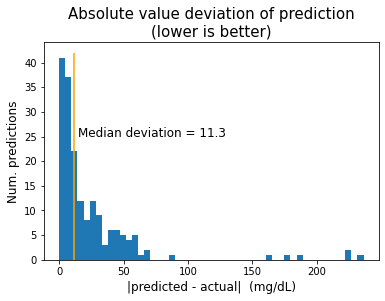

In [107]:
plt.hist(rfr_scores*-1, bins=50);
plt.title('Absolute value deviation of prediction\n(lower is better)', fontsize=15)
plt.xlabel('|predicted - actual|  (mg/dL)', fontsize=12)
plt.ylabel('Num. predictions', fontsize=12)
plt.vlines(x=11.3, ymin=0, ymax=42, color='orange')
plt.annotate('Median deviation = 11.3', xy=(15, 25), fontsize=12)
plt.savefig(r'..\reports\figures\3-5-2\RF_regressor_abs_deviation.png', bbox_inches='tight')

## Show Confusion Matrix for RF models

In [15]:
y_3class

,glucose_tolerance
combined_col_name,
1076_10_FBG,2
1062_8_FBG,1
1093_9_FBG,0
1060_8_RBG,1
1091_10_FBG,0
1092_9_RBG,1
1093_10_RBG,0
1082_10_FBG,2
1060_9_RBG,1


In [63]:
y_pred_3class

array(['impaired', 'impaired', 'normal', 'impaired', 'normal', 'impaired',
       'normal', 'impaired', 'impaired', 'impaired', 'impaired', 'normal',
       'impaired', 'impaired', 'diabetic', 'impaired', 'impaired',
       'normal', 'impaired', 'diabetic', 'diabetic', 'normal', 'impaired',
       'diabetic', 'impaired', 'impaired', 'impaired', 'normal',
       'impaired', 'impaired', 'impaired', 'diabetic', 'normal',
       'impaired', 'impaired', 'impaired', 'diabetic', 'diabetic',
       'diabetic', 'impaired', 'impaired', 'impaired', 'impaired',
       'impaired', 'impaired', 'impaired', 'impaired', 'diabetic',
       'impaired', 'impaired', 'impaired', 'impaired', 'diabetic',
       'impaired', 'impaired', 'impaired', 'impaired', 'impaired',
       'impaired', 'normal'], dtype=object)

In [108]:
rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
cv = RepeatedStratifiedKFold(n_splits=12, n_repeats=1, random_state=10)
y_pred_3class_num = cross_val_predict(rfc, 
                                  X=X_all, y=y_3class_num, 
                                  cv=cv)

In [104]:
# Cross val PREDICT
rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
cv = RepeatedStratifiedKFold(n_splits=12, n_repeats=1, random_state=10)
y_pred_3class = cross_val_predict(rfc, 
                                  X=X_all, y=y_3class, 
                                  cv=cv)

In [ ]:
# Cross val SCORE
rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
cv = RepeatedStratifiedKFold(n_splits=12, n_repeats=1, random_state=10)
y_pred_3class = cross_val_score(rfc, 
                                X=X_all, y=y_3class, 
                                cv=cv)

## Get the ROC AUC for each split in the CV:
https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

In [155]:
for i, (train, test) in enumerate(cv.split(X, y)):
    print(train)

[ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 40 41 42 43 44 48 49 50 51 52
 53 54 55 56 57 58 59]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 19 20 21 22 23 24 25 26 27
 28 29 30 31 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52
 53 54 55 56 57 58 59]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 35 36 37 38 39 40 41 43 44 45 46 47 48 49 50
 52 53 54 55 56 57 59]
[ 0  1  2  3  4  5  6  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25 26 27
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52
 53 54 55 56 57 58 59]
[ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 31 32 33 34 35 36 37 38 39 40 41 42 43 45 46 47 48 49 50 51
 52 53 54 55 56 58 59]
[ 0  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 44 45 46 47 48 49 50 51
 52 53 54

In [152]:
X

i,l_0,l_1,l_2,l_3,l_4,l_5,l_6,l_7,l_8,l_9,...,m_682,m_368,m_340,m_616,m_557,m_169,m_213,m_24,m_505,m_441
1076_10_FBG,20.405355,21.533648,20.665848,24.400930,19.378685,23.049698,28.481360,19.316892,24.328078,19.478253,...,20.428816,22.604717,22.702338,19.415497,19.856909,24.882649,20.930852,27.101820,20.783983,22.129900
1062_8_FBG,23.313111,24.586227,23.731244,26.811664,22.709669,26.254519,30.305095,22.008084,26.237893,23.669177,...,20.008418,22.352220,22.346725,19.461693,19.968729,24.605962,21.303302,27.465801,21.295813,22.281020
1093_9_FBG,23.218699,24.375151,23.038733,26.708762,21.722467,26.085255,29.595696,22.149967,25.628550,23.638288,...,20.080867,22.559027,22.629048,20.060549,20.559004,25.488336,19.581065,26.936184,19.838921,21.851189
1060_8_RBG,24.012349,25.685664,24.916555,25.977120,23.985839,27.293718,31.938325,22.246767,27.005584,24.827176,...,20.328434,22.667628,22.896178,20.147306,20.708589,24.568105,23.318774,27.795283,21.858665,22.537343
1091_10_FBG,24.302356,25.422294,24.042666,27.313654,22.321161,26.913271,30.455412,22.475813,26.363764,23.854459,...,20.520524,22.706016,22.690580,20.307133,20.440626,24.949127,19.437282,27.044044,20.366726,21.887095
1092_9_RBG,23.901455,24.936916,24.162971,27.337061,23.184906,26.682437,30.690269,22.495336,26.325506,23.984926,...,20.422656,22.951906,23.100061,20.483145,21.073392,25.119634,23.268904,27.561589,21.397133,22.607897
1093_10_RBG,23.883301,24.779941,23.627979,27.415597,22.795191,26.236176,29.854529,22.337295,25.798043,23.349277,...,20.534701,23.038372,23.285365,20.589639,21.153981,25.008021,23.345351,27.863524,21.742171,22.614663
1082_10_FBG,23.387975,24.696276,24.085858,27.230430,22.878785,26.307266,30.106764,22.612902,26.021376,23.659766,...,20.521336,22.868909,22.860677,19.892074,20.243994,24.852314,22.052052,27.438797,21.247307,22.346741
1060_9_RBG,24.421692,25.054941,23.169508,27.598719,22.397716,26.123572,29.717328,22.790052,25.559916,22.258087,...,18.750308,22.595668,22.718984,19.197231,20.482364,25.064357,17.810755,26.430616,18.004667,22.303816
1101_9_FBG,23.463756,24.934805,24.010849,27.126653,22.703282,26.680311,30.314104,22.526302,26.226352,24.184003,...,20.890070,22.982584,22.902586,20.260775,20.504512,24.826840,19.078979,26.924145,20.352671,21.932740


ValueError: Expected 'estimator' to be a binary classifier, but got RandomForestClassifier fit on multiclass (3 classes) data

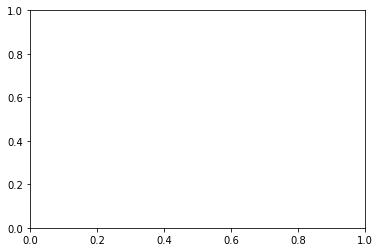

In [157]:
rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
cv = RepeatedStratifiedKFold(n_splits=12, n_repeats=1, random_state=10)
X = X_all
y = y_3class
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    rfc.fit(X.iloc[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        rfc,
        X.iloc[test],
        y[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic example",
)
ax.legend(loc="lower right")
plt.show()

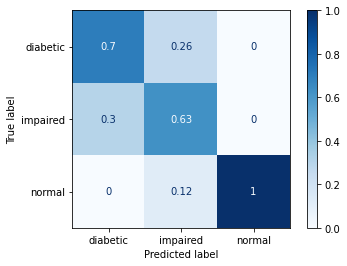

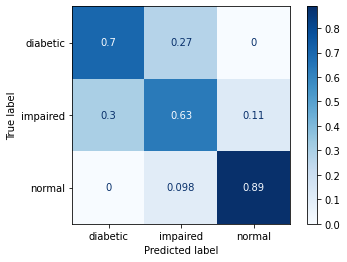

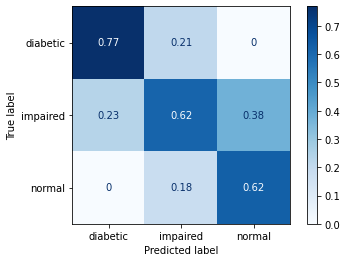

In [105]:
# Compare confusion matrix between subsets of metabolite features for Random Forest
for dataset in [X_all, X_only_conv, X_only_signf]:
    y_pred = cross_val_predict(rfc, X=dataset, y=y_3class, cv=cv)
    ConfusionMatrixDisplay.from_predictions(y_3class, y_pred, 
                                            cmap='Blues',
                                            normalize='pred')

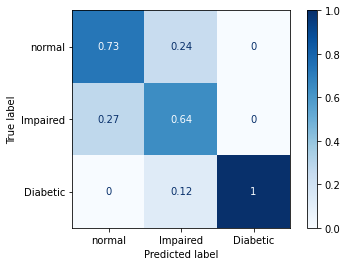

In [106]:
ConfusionMatrixDisplay.from_predictions(y_3class, y_pred_3class, 
                                        display_labels=['normal', 'Impaired', 'Diabetic'], 
                                        cmap='Blues',
                                        normalize='pred')

## Try making a ROC AUC curve for Random Forest multiclass

### roc_auc_score() requires y_true and y_score, but RF doesn't have a .decision_function() method to generate  score

### Therefore, use RF.predict_proba()

### See: https://laurenliz22.github.io/roc_curve_multiclass_predictions_random_forest_classifier

# Scoring metrics advice from Peng:


Figure 6 or 5: Results of machine learning including Random Forest – 20% complete
            Figure in early stages. 
@Peng I would greatly appreciate your expert feedback on how to best display results of machine learning models for:
-	Multiclass classification (predicting normal vs impaired vs diabetic), 
o	I’m working on a confusion matrix for the multiclass classification case. – Confusion matrix is a great way to display the prediction results for multi-class model. For visualization purpose, I would suggest to display one more figure: The RF probability distribution. For each sample, you will have three Prob values: Prob (normal), Prob (impaired) and Prob( diabetic). The sum of the three is 1. When you group samples from each category (e.g., normal), you can calculate the “distribution” of Prob for each predicted classes (Prob (normal), Prob (impaired) and Prob( diabetic) via boxplot or violin plot. We expect to see that for the group of “normal”, the boxplot/violin plot of “Prob (Normal)” is the highest, followed by Prob (impaired) and Prob( diabetic). … This figure can give an intuitive way to see the prediction distribution. I like the confusion table but the problem is that the confusion table is based on the “cutoff: RF use the highest prob to decide the outcome”. The Prob distribution is an unbiased way to display your prediction results.

-	Regression (predicting the blood glucose taken each week, or predicting OGTT) – A simply x-y plot with Pearson Correlation Coefficient or lm line can demonstrate the performance of RFR model
-	Comparing whether a model trained on random-fed data is meaningfully better than fasted data alone – A prediction score (Prob) comparison can demonstrate the difference. For example, you build a 3-calss model. For “normal samples”, you can show a boxplot/violin plot (Prob (Normal – random-fed)) vs (Prob (Normal – fasted)). Similarity, you can do this for each class to compile a figure panel.


In [138]:
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=10)
X_train, X_test, y_train, y_test = train_test_split(X_all, y_3class, test_size=0.3, random_state=10)
rfc.fit(X_train, y_train)
y_score = rfc.predict_proba(X_test)

In [139]:
y_score

array([[0.52, 0.43, 0.05],
       [0.21, 0.64, 0.15],
       [0.5 , 0.47, 0.03],
       [0.09, 0.55, 0.36],
       [0.17, 0.59, 0.24],
       [0.16, 0.37, 0.47],
       [0.16, 0.74, 0.1 ],
       [0.17, 0.6 , 0.23],
       [0.43, 0.54, 0.03],
       [0.27, 0.58, 0.15],
       [0.1 , 0.84, 0.06],
       [0.26, 0.62, 0.12],
       [0.29, 0.59, 0.12],
       [0.38, 0.59, 0.03],
       [0.32, 0.47, 0.21],
       [0.15, 0.55, 0.3 ],
       [0.45, 0.42, 0.13],
       [0.28, 0.51, 0.21]])

In [133]:
roc_auc_score(y_test, y_score, 
              multi_class='ovo',
              average='macro')

0.8940972222222223

In [134]:
roc_curve(y_test, y_score)

ValueError: multiclass format is not supported